### References

- [Diabetes Dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes)
- [Gradient Boosted Regression Example](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py)
- [Bayesian Hyperparameter Search](https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html)
- [Gaussian process explanation]( https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html)

In [27]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.plots import plot_objective, plot_histogram
import matplotlib.pyplot as plt
from yellowbrick.regressor import residuals_plot, prediction_error

my_seed = 42

In [35]:
# Load dataset
X, y = load_diabetes(return_X_y = True, as_frame = True)

combi = pd.concat([X, y], axis = 1)

n_features = X.shape[1]

In [3]:
combi

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930,220.0


In [4]:
# CV split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.1, random_state = my_seed)

In [5]:
X.sample(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
160,-0.009147,-0.044642,-0.062252,-0.074528,-0.023584,-0.013214,0.004460,-0.039493,-0.035817,-0.046641
80,0.070769,-0.044642,0.012117,0.042530,0.071357,0.053487,0.052322,-0.002592,0.025393,-0.005220
334,-0.060003,0.050680,-0.047163,-0.022885,-0.071743,-0.057681,-0.006584,-0.039493,-0.062913,-0.054925


In [6]:
y.sample(3)

169    152.0
302    198.0
162    172.0
Name: target, dtype: float64

## EDA

In [7]:
X['sex'].value_counts()

-0.044642    235
 0.050680    207
Name: sex, dtype: int64

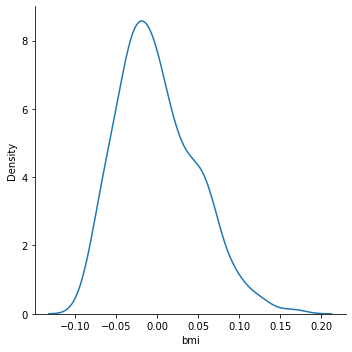

In [8]:
sns.displot(
    X,
    x = "bmi",
    kind = 'kde'
)

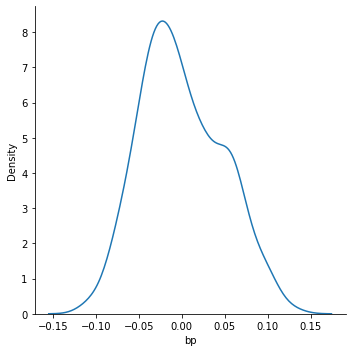

In [9]:
sns.displot(
    X,
    x = "bp",
    kind = 'kde'
)

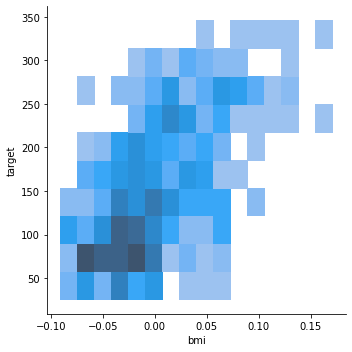

In [10]:
sns.displot(
    combi,
    x = "bmi",
    y = "target"
)

## Model

In [11]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = my_seed) 

In [36]:

# model pipelines
pipelines = {
    'linear regression' : make_pipeline(StandardScaler(), LinearRegression()),
    'gradient boosting' : make_pipeline(StandardScaler(), GradientBoostingRegressor()),
    'random forest' : make_pipeline(StandardScaler(), RandomForestRegressor())
}

Search gradient boosted model hyperparameter space for optimal parameters using scikit-opt

https://scikit-optimize.github.io/stable/auto_examples/hyperparameter-optimization.html#sphx-glr-auto-examples-hyperparameter-optimization-py

In [55]:
# NOTE: Had to downgrade to scikit-learn 0.23.2 to avoid an error regarding 'iid':
# pip install -Iv scikit-learn==0.23.2

opt = BayesSearchCV(
    pipelines['gradient boosting'],
    {

    "gradientboostingregressor__min_samples_split" : (2, 20),
#    "gradientboostingregressor__min_samples_leaf" : (1, 20),   
    "gradientboostingregressor__n_estimators" : (100, 300),
    "gradientboostingregressor__max_depth" : (1, 5),
    "gradientboostingregressor__max_features": (2, n_features),
    "gradientboostingregressor__learning_rate" : (10**-5, 0.8, 'log-uniform')
    },
    cv = kf, # use k-fold cross validation
    random_state = my_seed,
    n_iter = 30,
    n_jobs = 8
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best params: %s" % str(opt.best_params_))

/home/cambonator/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/cambonator/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/cambonator/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/cambonator/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/cambonator/anaconda3/lib/python3.7/site-packages/s

val. score: 0.41534121914268674
test score: 0.5780905566781522
best params: OrderedDict([('gradientboostingregressor__learning_rate', 0.03200464817593894), ('gradientboostingregressor__max_depth', 1), ('gradientboostingregressor__max_features', 10), ('gradientboostingregressor__min_samples_split', 2), ('gradientboostingregressor__n_estimators', 300)])


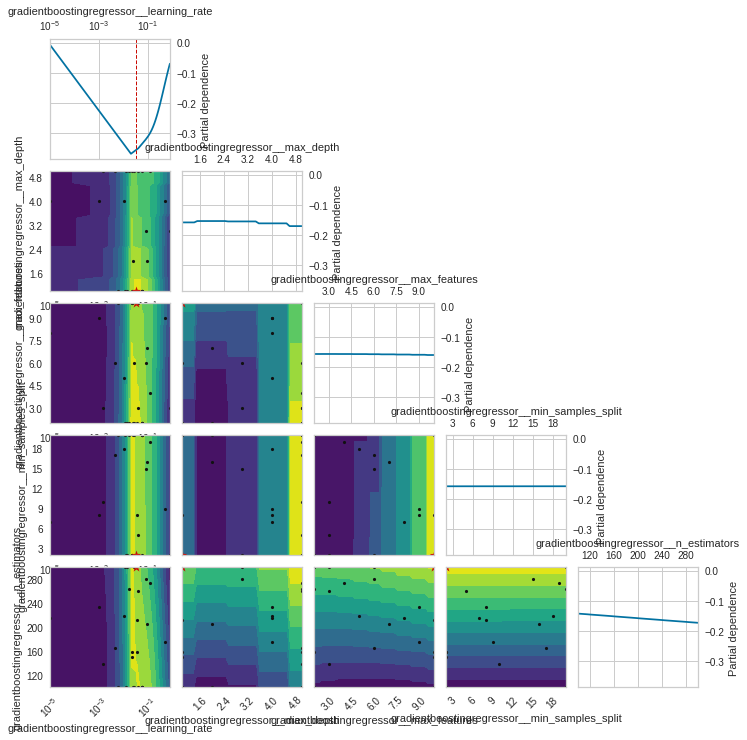

In [56]:
_ = plot_objective(
    opt.optimizer_results_[0]
)
plt.show()

In [43]:
10**0

1

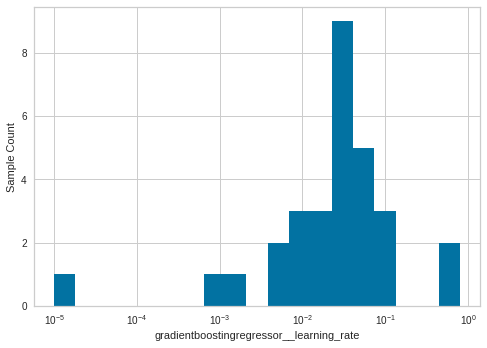

In [58]:
_ = plot_histogram(opt.optimizer_results_[0], 0)
plt.show()

In [45]:
#from skopt.plots import plot_convergence
#plot_convergence(opt)

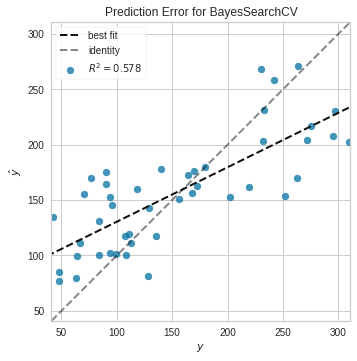

In [59]:
_ = prediction_error(opt, X_test, y_test)

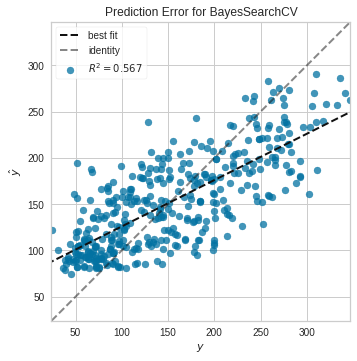

In [60]:
_ = prediction_error(opt, X_train, y_train)

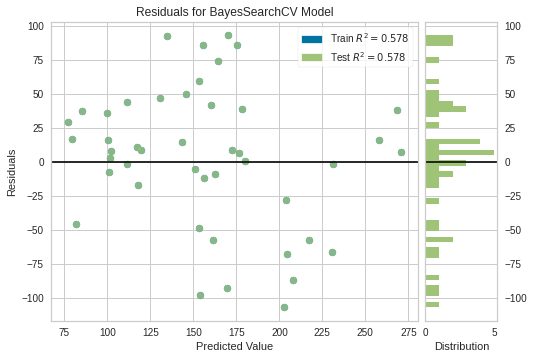

In [61]:
_ = residuals_plot(
    opt, X_test, y_test
)

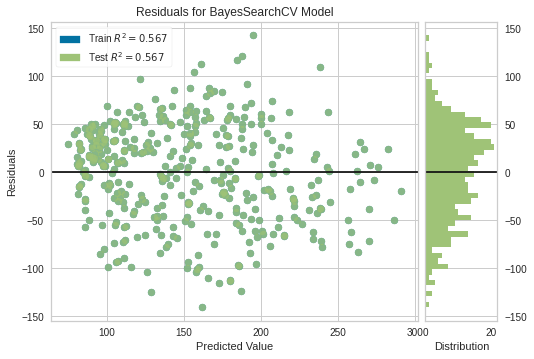

In [62]:
_ = residuals_plot(
    opt, X_train, y_train
)